# ISYE 6740 Project - NBA Players Career Trajectory Prediction
### Author: Daniel Jiang, Nafiz Haider

The National Basketball Association (NBA) is the premier professional basketball association in the world. This sport has produced numerous stars and all time greats. There have been even more players that have excelled in their first, or rookie, NBA seasons. However, we have seen that a more accurate prediction of a player’s trajectory is from their second season.

In [1]:
# load libraries
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import pairwise_distances

import requests
import re
import csv
from bs4 import BeautifulSoup

from sklearn.preprocessing import MinMaxScaler

In [2]:
def table_creator(row_array):
    fig = plt.figure(dpi=100)
    ax = fig.add_subplot(1,1,1)
    table_data=[['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5'],
               row_array]
    table = ax.table(cellText=table_data, loc='top')
    table.set_fontsize(14)
    table.scale(2,2)
    ax.axis('off')
    plt.show()


In [3]:
def extract_bling_info(soup):
    """ number of All-star and All-NBA selections can be found in the "bling" element """
    
    ALL_STAR, ALL_NBA = 0, 0
    bling = soup.find(id="bling")
    if bling:
        bling = bling.find_all('li')
        for b in bling:
            text = b.a.text
            if text.find("All Star") != -1:
                if text.find("x") != -1:
                    ALL_STAR = int(text.split("x")[0])
                else:
                    ALL_STAR = 1
            elif text.find("All-NBA") != -1:
                if text.find("x") != -1:
                    ALL_NBA = int(text.split("x")[0])
                else:
                    ALL_NBA = 1
    return ALL_STAR, ALL_NBA


def scrape_player_career(player_list):
    """
    given player ID, return player's career averages as pandas data frame
    """
    
    out_path = 'data/second_yrs_career_1990-2010.csv'
    csv_file = open(out_path, 'w')
    csv_writer = csv.writer(csv_file)
    features = ['GS_PCT','MP','FG','FGA','2P','2PA','3P','3PA','FT','FTA','ORB','DRB','TRB',
                    'AST','STL','BLK','TOV','PF','PTS','FG%','2P%','3P%','eFG%','FT%','ALL_STAR','ALL_NBA']
    
    csv_writer.writerow(features)
    
    for i in range(len(player_list)):
        player_id = player_list.iloc[i]

        URL = 'https://www.basketball-reference.com/players/{}/{}.html'.format(player_id[0], player_id)
        r = requests.get(URL)
        soup = BeautifulSoup(r.text, "html5lib")
        
        # extract desired columns from per-game table, career row 
        # note each has a try except due to missing data for some players
        # example: if player has never attempted a three point shot
        career_per = soup.find(id="per_game").tfoot.contents[0]
        
        try:
            G = career_per.contents[5].contents[0]
        except:
            G = 0
        try:
            GS = career_per.contents[6].contents[0]
        except:
            GS = 0            
        if int(G) == 0:
            GS_PCT = 0
        else:
            GS_PCT = round(int(GS)/int(G), 2)
            
        try:
            MP = career_per.contents[7].contents[0]
        except:
            MP = 0
        try:
            FG = career_per.contents[8].contents[0]
        except:
            FG = 0
        try:
            FGA = career_per.contents[9].contents[0]
        except:
            FGA = 0
        try:
            FG_PCT = career_per.contents[10].contents[0]
        except:
            FG_PCT = 0
        try:
            THREE_P = career_per.contents[11].contents[0]
        except:
            THREE_P = 0
        try:
            THREE_PA = career_per.contents[12].contents[0]
        except:
            THREE_PA = 0
        try:
            THREE_PCT = career_per.contents[13].contents[0]
        except:
            THREE_PCT = 0
        try:
            TWO_P = career_per.contents[14].contents[0]
        except:
            TWO_P = 0
        try:
            TWO_PA = career_per.contents[15].contents[0]
        except:
            TWO_PA = 0
        try:
            TWO_PCT = career_per.contents[16].contents[0]
        except:
            TWO_PCT = 0
        try:
            EFG_PCT = career_per.contents[17].contents[0]
        except:
            EFG_PCT = 0
        try:
            FT = career_per.contents[18].contents[0]
        except:
            FT = 0
        try:
            FTA = career_per.contents[19].contents[0]
        except:
            FTA = 0
        try:
            FT_PCT = career_per.contents[20].contents[0]
        except:
            FT_PCT = 0
        try:
            ORB = career_per.contents[21].contents[0]
        except:
            ORB = 0
        try:
            DRB = career_per.contents[22].contents[0]
        except:
            DRB = 0
        try:
            TRB = career_per.contents[23].contents[0]
        except:
            TRB = 0
        try:
            AST = career_per.contents[24].contents[0]
        except:
            AST = 0
        try:
            STL = career_per.contents[25].contents[0]
        except:
            STL = 0
        try:
            BLK = career_per.contents[26].contents[0]
        except:
            BLK = 0
        try:
            TOV = career_per.contents[27].contents[0]
        except:
            TOV = 0
        try:
            PF = career_per.contents[28].contents[0]
        except:
            PF = 0
        try:
            PTS = career_per.contents[29].contents[0]
        except:
            PTS = 0


        ALL_STAR, ALL_NBA = extract_bling_info(soup)            
        
        row = [GS_PCT,MP,FG,FGA,TWO_P,TWO_PA,THREE_P,THREE_PA,FT,FTA,ORB,DRB,TRB,
                    AST,STL,BLK,TOV,PF,PTS,FG_PCT,TWO_PCT,THREE_PCT,EFG_PCT,FT_PCT,ALL_STAR,ALL_NBA]
        csv_writer.writerow(row)

In [4]:
# all current (2019-2020) second-year players
# these are the players we are predicting the future of
second_yrs_current_season_pd = pd.read_csv('data/second_yrs_season_2019-2020.csv', header=1)
second_yrs_current_season_players_list = second_yrs_current_season_pd.iloc[:,1].to_numpy()
second_yrs_current_season = second_yrs_current_season_pd.to_numpy()[0:,8:32].astype(float)
second_yrs_current_season = np.nan_to_num(second_yrs_current_season)

# list of players and their second-year stats for those who played 1990-2010
second_yrs_1990_2010_season_pd = pd.read_csv('data/second_yrs_season_1990-2010.csv', header=1)
second_yrs_1990_2010_season = second_yrs_1990_2010_season_pd.to_numpy()[0:,8:32].astype(float)
second_yrs_1990_2010_season = np.nan_to_num(second_yrs_1990_2010_season)

# extract player_list from second_yrs_1990_2010_season
player_list = second_yrs_1990_2010_season_pd.iloc[:,1]
player_list = player_list.str.split('\\').str[1]

In [5]:
# run in order to generate second_yrs_career_1990-2010.csv file
# note this is already generated
#scrape_player_career(player_list)

In [6]:
# second_yrs_career_1990-2010.csv is the career stats for 
# players who played second season between 1990 and 2010
second_yrs_1990_2010_career_pd = pd.read_csv('data/second_yrs_career_1990-2010.csv')
second_yrs_1990_2010_career = second_yrs_1990_2010_career_pd.to_numpy()[0:,:24].astype(float)
second_yrs_1990_2010_career = np.nan_to_num(second_yrs_1990_2010_career)
all_stars = second_yrs_1990_2010_career_pd.to_numpy()[0:,24].astype(float)
all_nbas = second_yrs_1990_2010_career_pd.to_numpy()[0:,25].astype(float)
gs_percents = second_yrs_1990_2010_career_pd.to_numpy()[0:,0].astype(float)
minutes_per_game = second_yrs_1990_2010_career_pd.to_numpy()[0:,1].astype(float)

In [7]:
# normalize data before performing PCA
scaler = MinMaxScaler(feature_range=(0,1))
second_yrs_1990_2010_career_normalized = scaler.fit_transform(second_yrs_1990_2010_career)

In [8]:
# PCA Dimension reduction of career data
pca = PCA(n_components=5)
pca.fit(second_yrs_1990_2010_career_normalized)
#variance = pca.explained_variance_ratio_
reduced_representation_career_data = pca.transform(second_yrs_1990_2010_career_normalized)

------------------------------------------------------------------------------------
KMEANS CLUSTERING
------------------------------------------------------------------------------------
ALL STAR APPEARANCES PER CLUSTER:


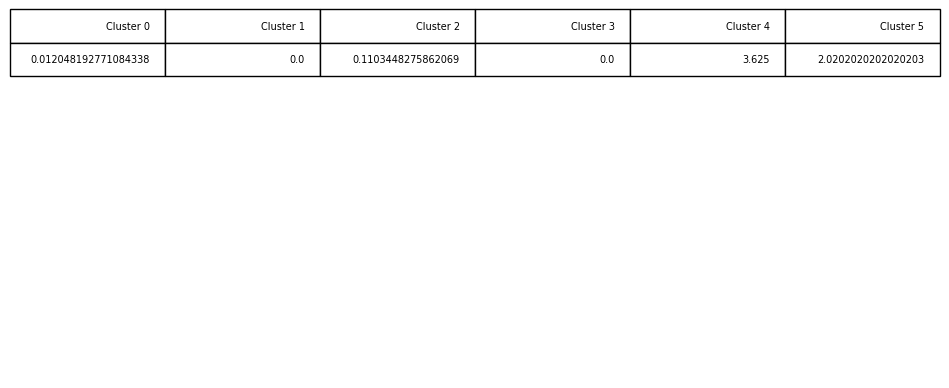

ALL NBA APPEARANCES PER CLUSTER:


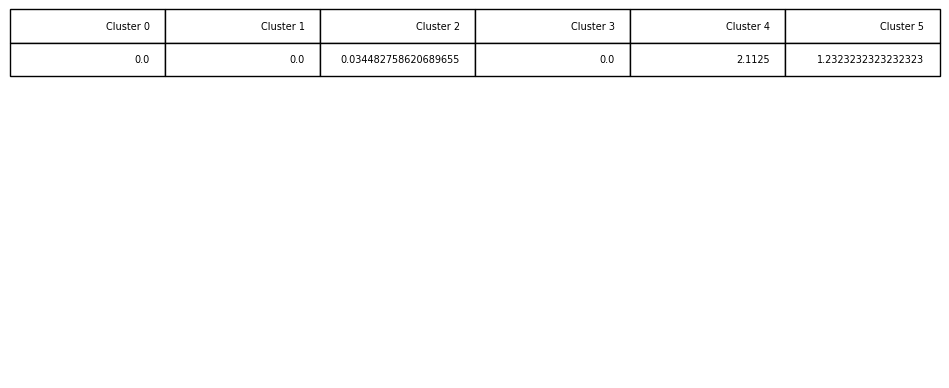

PERCENTAGE OF GAMES STARTED PER CLUSTER:


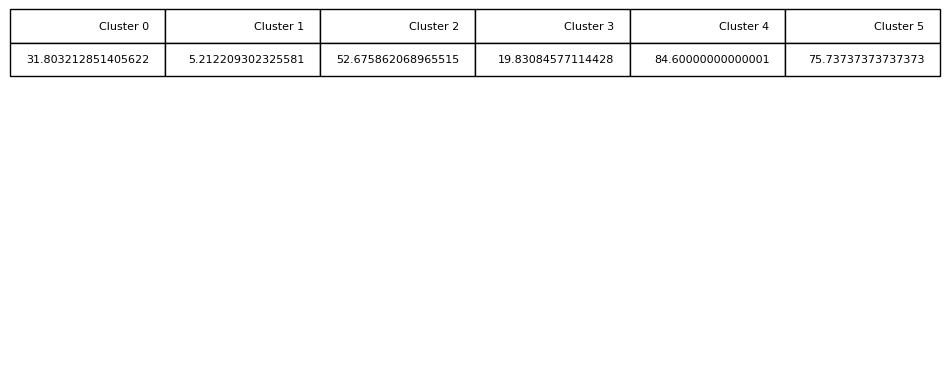

MINUTES PER GAME AVERAGES PER CLUSTER:


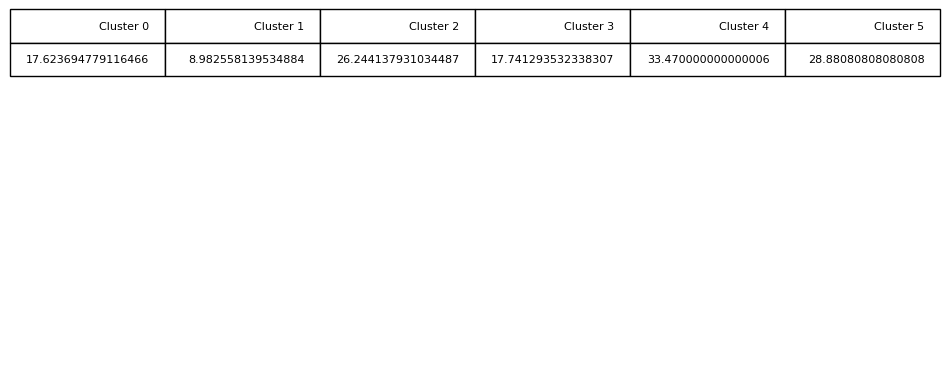

PLAYERS PER CLUSTER:


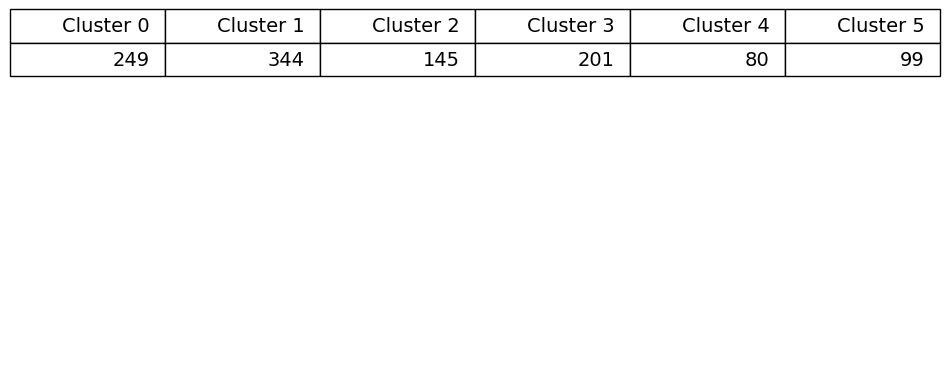

------------------------------------------------------------------------------------
------------------------------------------------------------------------------------
jamesle01
LEBRON Cluster: 4
Number of cluster 4 players: 80
Players in other clusters: 1038
------------------------------------------------------------------------------------


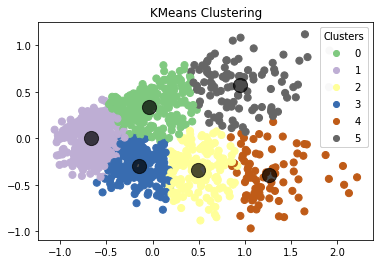

------------------------------------------------------------------------------------
KMEDOIDS CLUSTERING
------------------------------------------------------------------------------------
ALL STAR APPEARANCES PER CLUSTER:


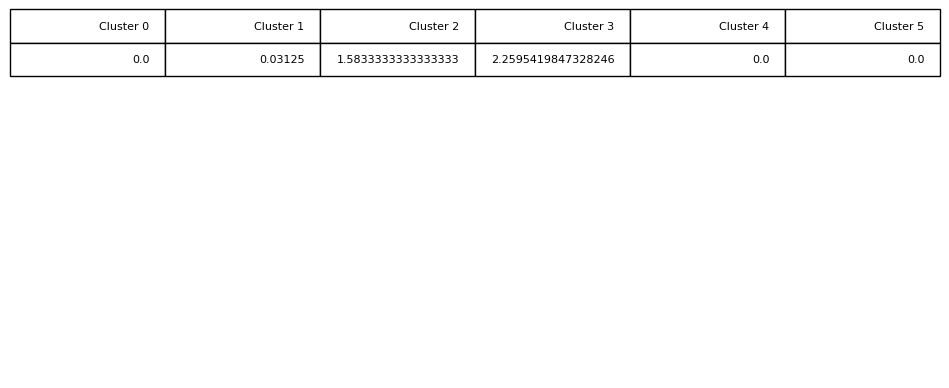

ALL NBA APPEARANCES PER CLUSTER:


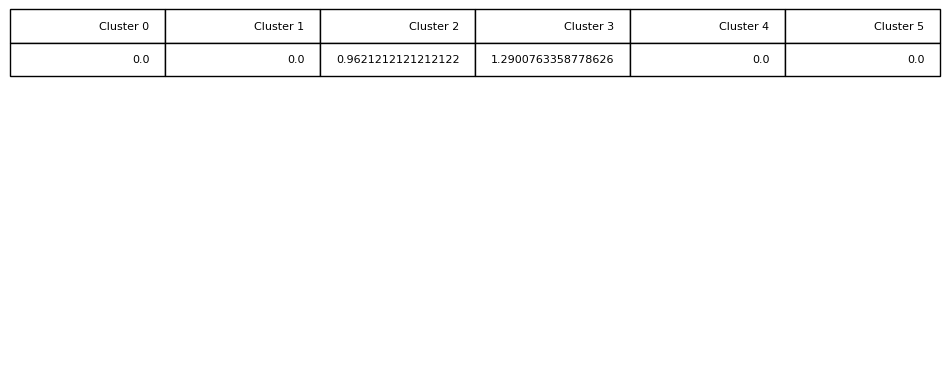

PERCENTAGE OF GAMES STARTED PER CLUSTER:


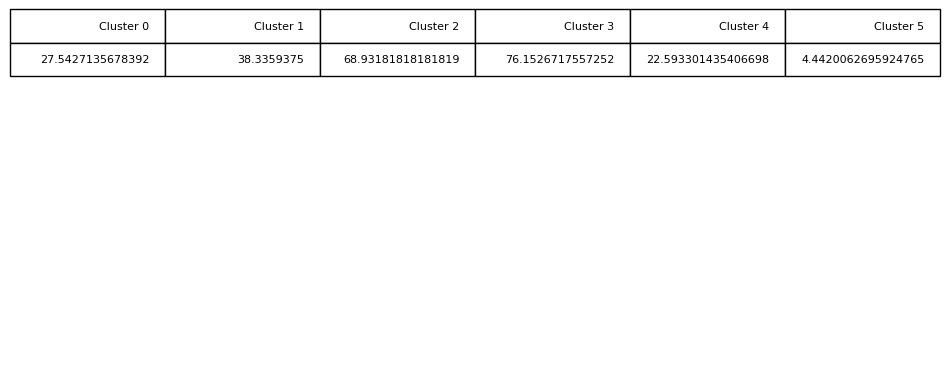

MINUTES PER GAME AVERAGES PER CLUSTER:


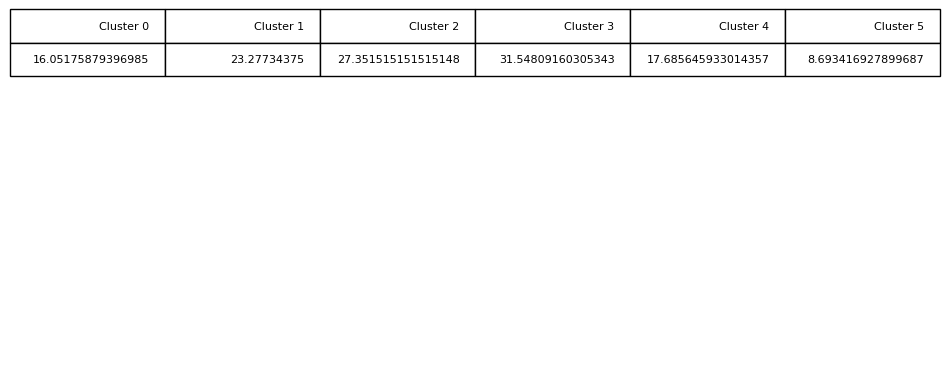

PLAYERS PER CLUSTER:


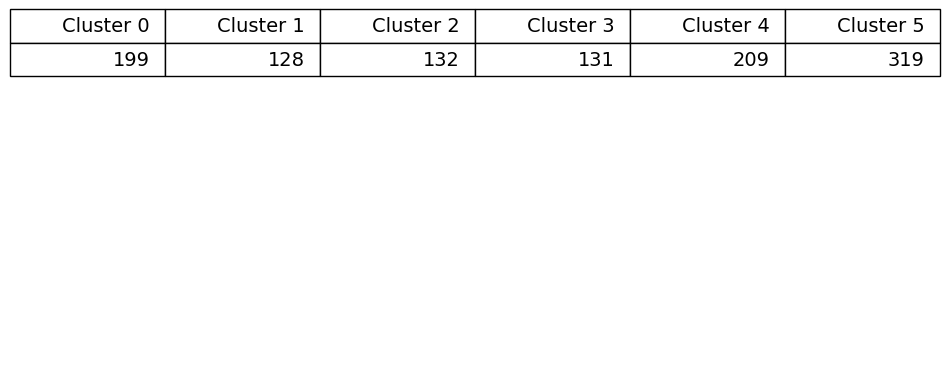

------------------------------------------------------------------------------------
------------------------------------------------------------------------------------
jamesle01
LEBRON Cluster: 3
Number of cluster 3 players: 131
Players in other clusters: 987
------------------------------------------------------------------------------------


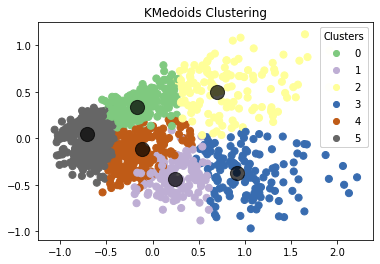

In [9]:

for classifier in ['KMeans', 'KMedoids']:
    # kmeans clustering of career data into 6 clusters
    print('------------------------------------------------------------------------------------')
    if classifier == 'KMeans':
        print('KMEANS CLUSTERING')
        clf = KMeans(n_clusters=6, random_state=0).fit(reduced_representation_career_data)
        career_labels_kmeans = clf.labels_
    else:
        print('KMEDOIDS CLUSTERING')
        clf = KMedoids(n_clusters=6, random_state=0).fit(reduced_representation_career_data)
        career_labels_kmedoids = clf.labels_

    career_labels = clf.labels_ # cluster labels
    career_centers = clf.cluster_centers_ # cluster centers; interesting to see which players

    # categorical averages per cluster including: all star appearances, all nba selections, 
    # percent games started, average minutes per game, and players per cluster
    career_all_stars_averages = np.zeros(len(set(career_labels)))
    career_all_nba_averages = np.zeros(len(set(career_labels)))
    gs_percents_averages = np.zeros(len(set(career_labels)))
    minutes_per_game_averages = np.zeros(len(set(career_labels)))
    players_per_cluster = np.zeros(len(set(career_labels)))
    for i in range(len(set(career_labels))):
        # indices of particular cluster
        indices = np.where(career_labels == i)[0]
        # average all star appearances per cluster
        all_stars_average = np.average(all_stars[indices])
        career_all_stars_averages[i] = all_stars_average
        # average all nba appearances per cluster
        all_nba_average = np.average(all_nbas[indices])
        career_all_nba_averages[i] = all_nba_average
        # average game start percentagers per cluster
        gs_percents_average = np.average(gs_percents[indices])
        gs_percents_averages[i] = gs_percents_average*100
        # average minutes per game per cluster
        minutes_per_game_average = np.average(minutes_per_game[indices])
        minutes_per_game_averages[i] = minutes_per_game_average
        players_per_cluster[i] = len(indices)

    print('------------------------------------------------------------------------------------')
    print('ALL STAR APPEARANCES PER CLUSTER:')
    table_creator(career_all_stars_averages.tolist())
    print('ALL NBA APPEARANCES PER CLUSTER:')
    table_creator(career_all_nba_averages.tolist())
    print('PERCENTAGE OF GAMES STARTED PER CLUSTER:')
    table_creator(gs_percents_averages.tolist())
    print('MINUTES PER GAME AVERAGES PER CLUSTER:')
    table_creator(minutes_per_game_averages.tolist())
    print('PLAYERS PER CLUSTER:')
    table_creator(players_per_cluster.astype(int).tolist())
    print('------------------------------------------------------------------------------------')

    # printing out lebron info
    # this would be the "hall of fame" cluster
    print('------------------------------------------------------------------------------------')
    print(player_list[798])
    lebron_cluster = str(career_labels[798])
    print('LEBRON Cluster: ' + str(lebron_cluster))
    print('Number of cluster ' + str(lebron_cluster) + ' players: ' + str(len((career_labels[career_labels == int(lebron_cluster)]))))
    print('Players in other clusters: ' + str(len((career_labels[career_labels != int(lebron_cluster)]))))
    print('------------------------------------------------------------------------------------')

    # Graphing cluster assignment data points
# using only 2 dimensions of PCA
    fig, ax = plt.subplots()
    scatter = ax.scatter(reduced_representation_career_data[:, 0], reduced_representation_career_data[:, 1], c=career_labels, s=50, cmap='Accent')
    # produce a legend with the unique colors from the scatter
    legend = ax.legend(*scatter.legend_elements(),
                        loc="best", title="Clusters")
    ax.add_artist(legend)
    plt.scatter(career_centers[:, 0], career_centers[:, 1], c='black', s=200, alpha=0.7)
    plt.title(classifier + ' Clustering')
    plt.show()

------------------------------------------------------------------------------------
KMEANS CLUSTERING
TOTAL PLAYERS IN EACH CLUSTER:


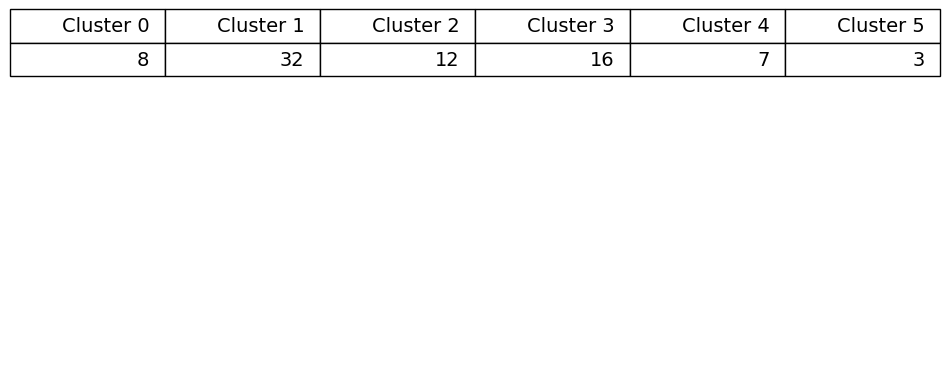

CLUSTER: 0
['Mohamed Bamba' 'Hamidou Diallo' 'Harry Giles' 'Chandler Hutchison'
 'Omari Spellman' 'Moritz Wagner' 'Kenrich Williams' 'Robert Williams']
CLUSTER: 1
['Kostas Antetokounmpo' 'Thanasis Antetokounmpo' 'Jonah Bolden'
 'Ryan Broekhoff' 'Deonte Burton' 'Joe Chealey' 'Chris Chiozza'
 'Gary Clark' 'Antonius Cleveland' 'Drew Eubanks' 'Melvin Frazier'
 'Josh Gray' 'Dusty Hannahs' 'Isaiah Hartenstein' 'Amile Jefferson'
 'Alize Johnson' 'B.J. Johnson' 'Rodions Kurucs' 'Daryl Macon'
 'J.P. Macura' 'Josh Magette' 'Chimezie Metu' 'D_anan Musa' 'Elie Okobo'
 'Theo Pinson' 'Zhaire Smith' 'Khyri Thomas' 'Jarrod Uthoff'
 'Jarred Vanderbilt' 'Derrick Walton' 'Yuta Watanabe' 'Johnathan Williams']
CLUSTER: 2
['Mikal Bridges' 'Bruce Brown' 'Troy Brown' 'Donte DiVincenzo'
 'Aaron Holiday' 'Kevin Huerter' 'Sviatoslav Mykhailiuk' 'Josh Okogie'
 'Duncan Robinson' 'Mitchell Robinson' 'Landry Shamet' 'Anfernee Simons']
CLUSTER: 3
['Grayson Allen' 'Keita Bates-Diop' 'Isaac Bonga' 'Jalen Brunson'
 'Jev

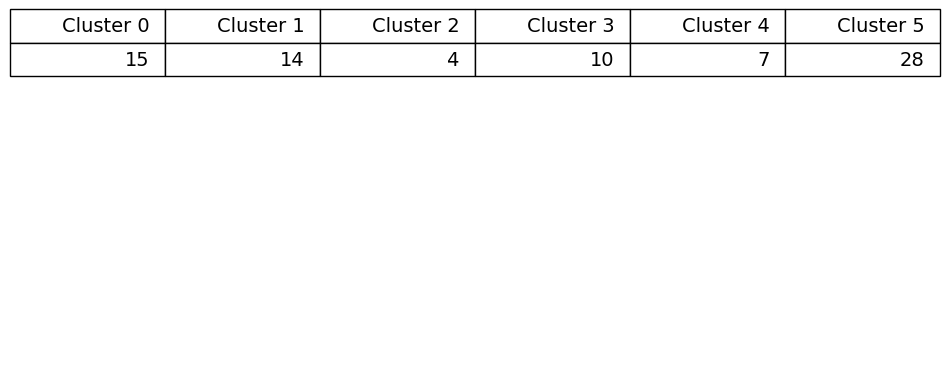

CLUSTER: 0
['Mohamed Bamba' 'Isaac Bonga' 'Jevon Carter' 'Jacob Evans' 'Harry Giles'
 'Brandon Goodwin' 'Isaiah Hartenstein' 'Frank Jackson' 'Rodions Kurucs'
 'Elie Okobo' 'Jerome Robinson' 'Allonzo Trier' 'Lonnie Walker'
 'Johnathan Williams' 'Robert Williams']
CLUSTER: 1
['Mikal Bridges' 'Troy Brown' 'Donte DiVincenzo' 'Aaron Holiday'
 'Chandler Hutchison' "De'Anthony Melton" 'Shake Milton'
 'Sviatoslav Mykhailiuk' 'Josh Okogie' 'Landry Shamet' 'Anfernee Simons'
 'Gary Trent' 'Moritz Wagner' 'Kenrich Williams']
CLUSTER: 2
['Marvin Bagley' 'Bruce Brown' 'Wendell Carter' 'Mitchell Robinson']
CLUSTER: 3
['Deandre Ayton' 'Miles Bridges' 'Luka Doncic' 'Shai Gilgeous-Alexander'
 "Devonte' Graham" 'Kevin Huerter' 'Jaren Jackson' 'Duncan Robinson'
 'Collin Sexton' 'Trae Young']
CLUSTER: 4
['Grayson Allen' 'Keita Bates-Diop' 'Jalen Brunson' 'Hamidou Diallo'
 'Kevin Knox' 'Omari Spellman' 'Brad Wanamaker']
CLUSTER: 5
['Kostas Antetokounmpo' 'Thanasis Antetokounmpo' 'Jonah Bolden'
 'Ryan Broekh

In [10]:
for classifier in ['KMeans', 'KMedoids']:
    # averages of second year performance per cluster
    #
    print('------------------------------------------------------------------------------------')
    if classifier == 'KMeans':
        print('KMEANS CLUSTERING')
        career_labels = career_labels_kmeans
    else:
        print('KMEDOIDS CLUSTERING')
        career_labels = career_labels_kmedoids
    second_year_cluster_averages = np.zeros((len(set(career_labels)), len(second_yrs_1990_2010_season[0])))
    for i in range(len(set(career_labels))):
        indices = np.where(career_labels == i)[0]
        cluster_average = np.average(second_yrs_1990_2010_season[indices], axis=0)
        second_year_cluster_averages[i] = cluster_average


    # assign projected cluster label to current second year players
    # using euclidean distance measurement to average second year performances of 1990-2010 clusters
    distances = np.array(pairwise_distances(second_yrs_current_season, second_year_cluster_averages, metric='euclidean'))
    second_year_current_labels = np.argmin(distances, axis=1)

    players_per_cluster = np.zeros(len(set(second_year_current_labels)))
    player_names = []
    for i in range(len(set(second_year_current_labels))):
        indices = np.where(second_year_current_labels == i)[0]
        players_per_cluster[i] = len(indices)
        player_names.append(second_yrs_current_season_players_list[indices])
    print('TOTAL PLAYERS IN EACH CLUSTER:')
    table_creator(players_per_cluster.astype(int).tolist())

    for i in range(6):
        print('CLUSTER: ' + str(i))
        print(player_names[i])
    '''
        fig = plt.figure(dpi=60)
        ax = fig.add_subplot(1,1,1)
        table_data=[
            ['Cluster ' + str(i)]]

        for player in player_names[i]:
            new_player = []
            new_player.append(player)
            table_data.append(new_player)
        table = ax.table(cellText=table_data, loc='center')
        table.set_fontsize(14)
        table.scale(1,2)
        ax.axis('off')
    plt.show()
    '''
    # making sure luka is clustered with lebron lol
    print('------------------------------------------------------------------------------------')
    luka_cluster = str(second_year_current_labels[24])
    print('LUKA CLUSTER: ' + str(luka_cluster))
    print('Number of cluster ' + str(luka_cluster) + ' players: ' + str(len((second_year_current_labels[second_year_current_labels == int(luka_cluster)]))))
    print('Players in other clusters: ' + str(len((second_year_current_labels[second_year_current_labels != int(luka_cluster)]))))
    print('------------------------------------------------------------------------------------')
    print('------------------------------------------------------------------------------------')

